In [1]:
import pandas as pd
import os
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import darts
import math

In [2]:
# from tqdm.keras import TqdmCallback
# import tensorflow_addons as tfa
# from keras_tqdm import TQDMNotebookCallback

In [3]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

In [4]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.utils.statistics import plot_acf
from darts.models.arima import ARIMA
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape

Importing plotly failed. Interactive plots will not work.


In [5]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TF to use only the CPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')  # obtiene las gpus instaladas
if len(gpus) > 0:   # si hay alguna gpu instalada
    # setea para alocar apenas a memória da GPU necessária para as alocações de tempo de execução
    tf.config.experimental.set_memory_growth(gpus[0], True) 
print(gpus)

[]


In [6]:
print(tf.__version__)
print(tf.keras.__version__)
import keras
print(keras.__version__)

2.1.0
2.2.4-tf
2.3.1


Using TensorFlow backend.


In [7]:
import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential    
from keras.layers import Dense
from keras.layers import Flatten

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

from keras.layers import LSTM

In [13]:
root = r'/'
data_path = r'data/dibanez/tesis/data_preprocesada/2.llenada/'

# Preparación y Entrenamiento

## Lectura de datos

In [14]:
def print_df(df):
  print(df.shape)
  return df.head()

In [15]:
data_file = data_path+'llenado_Lima_PUCP_HIT_agg_day_hour.csv'

In [16]:
df = pd.read_csv(root+data_file, parse_dates=True)
df.Fecha = pd.to_datetime(df.Fecha)
df=df.reset_index()
print_df(df)

(7029, 10)


,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc
0,0,2020-02-01 06:00:00,22.026791,NaN,27.115116,233.741749,0.188250,60.621361,66.380581,75.573104
1,1,2020-02-01 07:00:00,21.722877,NaN,111.537495,255.771884,0.569894,151.159816,169.414987,212.997443
2,2,2020-02-01 08:00:00,22.832072,NaN,416.345874,261.371965,1.555141,416.224706,407.368163,492.720706
3,3,2020-02-01 09:00:00,23.769869,NaN,557.163245,259.826929,2.571577,683.643427,696.240826,790.159728
4,4,2020-02-01 10:00:00,25.171561,NaN,843.467267,258.953148,3.368592,893.302314,946.676771,1034.689049


In [17]:
df.isna().sum()/len(df)

index          0.000000
Fecha          0.000000
Tamb           0.000000
Tmod           0.524257
Irradiancia    0.004410
Vdc            0.004410
Idc            0.004410
Paparente      0.004410
Pac            0.021909
Pdc            0.013089
dtype: float64

## Codificación de fechas


In [18]:
start = df.iloc[0]['Fecha']

In [19]:
df['Fecha_cod'] = pd.date_range(freq='H', start=start, periods=len(df))
df.head(13)

,index,Fecha,Tamb,Tmod,Irradiancia,Vdc,Idc,Paparente,Pac,Pdc,Fecha_cod
0,0,2020-02-01 06:00:00,22.026791,NaN,27.115116,233.741749,0.188250,60.621361,66.380581,75.573104,2020-02-01 06:00:00
1,1,2020-02-01 07:00:00,21.722877,NaN,111.537495,255.771884,0.569894,151.159816,169.414987,212.997443,2020-02-01 07:00:00
2,2,2020-02-01 08:00:00,22.832072,NaN,416.345874,261.371965,1.555141,416.224706,407.368163,492.720706,2020-02-01 08:00:00
3,3,2020-02-01 09:00:00,23.769869,NaN,557.163245,259.826929,2.571577,683.643427,696.240826,790.159728,2020-02-01 09:00:00
4,4,2020-02-01 10:00:00,25.171561,NaN,843.467267,258.953148,3.368592,893.302314,946.676771,1034.689049,2020-02-01 10:00:00
5,5,2020-02-01 11:00:00,24.871774,NaN,914.490592,258.534679,3.997132,1059.564233,1113.990698,1205.610495,2020-02-01 11:00:00
6,6,2020-02-01 12:00:00,24.464188,NaN,907.603342,258.100182,4.255034,1126.322782,1225.500565,1268.065384,2020-02-01 12:00:00
7,7,2020-02-01 13:00:00,24.225858,NaN,788.107984,258.256874,4.174545,1106.039742,1208.600875,1236.282651,2020-02-01 13:00:00
8,8,2020-02-01 14:00:00,23.270754,NaN,462.801055,247.997821,3.536506,936.701501,1054.297003,1071.263650,2020-02-01 14:00:00
9,9,2020-02-01 15:00:00,23.069030,NaN,428.230335,254.213123,2.608213,695.105191,764.096521,771.142338,2020-02-01 15:00:00


In [20]:
fechas_origen = df.Fecha

In [21]:
fechas_origen[:11+1]

0    2020-02-01 06:00:00
1    2020-02-01 07:00:00
2    2020-02-01 08:00:00
3    2020-02-01 09:00:00
4    2020-02-01 10:00:00
5    2020-02-01 11:00:00
6    2020-02-01 12:00:00
7    2020-02-01 13:00:00
8    2020-02-01 14:00:00
9    2020-02-01 15:00:00
10   2020-02-01 16:00:00
11   2020-02-02 06:00:00
Name: Fecha, dtype: datetime64[ns]

## Preprocesamiento

In [78]:
series_raw = TimeSeries.from_dataframe(df, 'Fecha_cod', ['Pac','Tamb'])#,'Irradiancia'])#, freq='H')
type(series_raw)

darts.timeseries.TimeSeries

In [79]:
col_obj = 'Pac'

In [80]:
series_raw[col_obj]

                             Pac
Fecha_cod                       
2020-02-01 06:00:00    66.380581
2020-02-01 07:00:00   169.414987
2020-02-01 08:00:00   407.368163
2020-02-01 09:00:00   696.240826
2020-02-01 10:00:00   946.676771
...                          ...
2020-11-19 22:00:00  1108.416667
2020-11-19 23:00:00   785.083333
2020-11-20 00:00:00   495.400000
2020-11-20 01:00:00   303.366667
2020-11-20 02:00:00   176.050000

[7029 rows x 1 columns]
Freq: H

In [81]:
series_raw[col_obj][:12]

                             Pac
Fecha_cod                       
2020-02-01 06:00:00    66.380581
2020-02-01 07:00:00   169.414987
2020-02-01 08:00:00   407.368163
2020-02-01 09:00:00   696.240826
2020-02-01 10:00:00   946.676771
2020-02-01 11:00:00  1113.990698
2020-02-01 12:00:00  1225.500565
2020-02-01 13:00:00  1208.600875
2020-02-01 14:00:00  1054.297003
2020-02-01 15:00:00   764.096521
2020-02-01 16:00:00   468.349693
2020-02-01 17:00:00    66.380581
Freq: H

In [82]:
len(series_raw)

7029

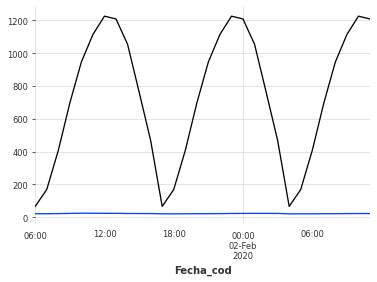

In [83]:
series_raw[0:30].plot()

### Imputación de datos faltantes

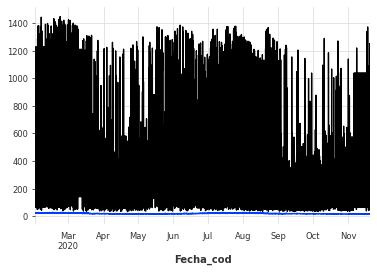

In [84]:
series_raw.plot()

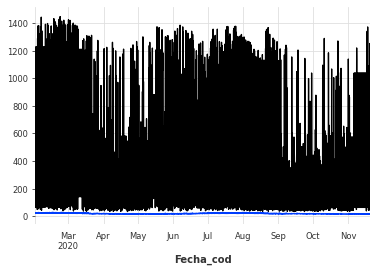

In [85]:
# TODO
filler = MissingValuesFiller()
series = filler.transform(series_raw, method='linear')
series.plot()

### Separación de conjuntos de entrenamiento y validación

In [86]:
train_perc = .8
math.ceil(len(series)*train_perc)

5624

In [87]:
val_len = int(len(series)*(1-train_perc))

In [88]:
val_len -= val_len%11

In [89]:
val_len

1397

In [90]:
train, val = series[:-val_len], series[-val_len:]

In [91]:
train

                            Pac       Tamb
Fecha_cod                                 
2020-02-01 06:00:00   66.380581  22.026791
2020-02-01 07:00:00  169.414987  21.722877
2020-02-01 08:00:00  407.368163  22.832072
2020-02-01 09:00:00  696.240826  23.769869
2020-02-01 10:00:00  946.676771  25.171561
...                         ...        ...
2020-09-22 17:00:00  523.983333  18.131548
2020-09-22 18:00:00  526.216667  18.430790
2020-09-22 19:00:00  323.666667  18.072161
2020-09-22 20:00:00  188.616667  17.686777
2020-09-22 21:00:00   71.160000  17.312989

[5632 rows x 2 columns]
Freq: H

In [92]:
# plot_acf(train)

## Visualización

In [93]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

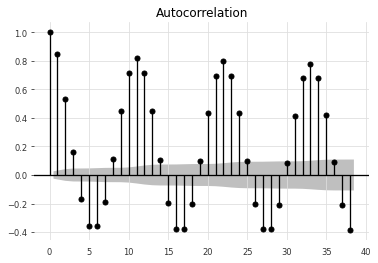

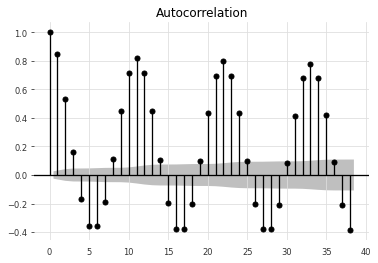

In [94]:
plot_acf(train[col_obj].values())

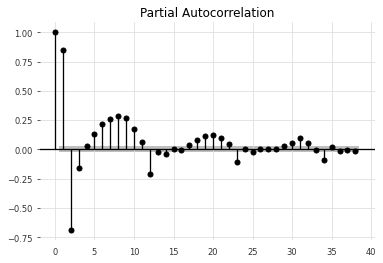

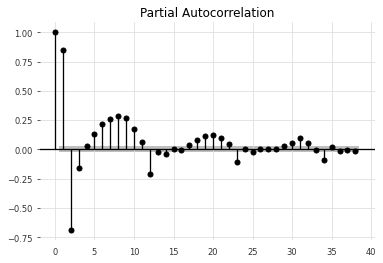

In [95]:
plot_pacf(train[col_obj].values())

## Training (ARIMA)

In [41]:
model = ARIMA(p=2, d=0, q=11)

In [ ]:
%%time
model.fit(train[col_obj])

In [43]:
train

                            Pac       Tamb  Irradiancia
Fecha_cod                                              
2020-02-01 06:00:00   66.380581  22.026791    27.115116
2020-02-01 07:00:00  169.414987  21.722877   111.537495
2020-02-01 08:00:00  407.368163  22.832072   416.345874
2020-02-01 09:00:00  696.240826  23.769869   557.163245
2020-02-01 10:00:00  946.676771  25.171561   843.467267
...                         ...        ...          ...
2020-09-22 17:00:00  523.983333  18.131548   355.140571
2020-09-22 18:00:00  526.216667  18.430790   358.687698
2020-09-22 19:00:00  323.666667  18.072161   225.177529
2020-09-22 20:00:00  188.616667  17.686777   134.005215
2020-09-22 21:00:00   71.160000  17.312989    54.119073

[5632 rows x 3 columns]
Freq: H

In [44]:
n_predict = 80

In [45]:
%%time
pred = model.predict(n_predict)
pred

AttributeError: 'NoneType' object has no attribute 'forecast'

In [46]:
val[:100]

                            Pac       Tamb  Irradiancia
Fecha_cod                                              
2020-09-22 22:00:00   45.321429  16.134004    26.341296
2020-09-22 23:00:00   40.388889  16.341793    44.194539
2020-09-23 00:00:00   98.133333  16.700497   103.832638
2020-09-23 01:00:00  139.200000  16.996799   163.824579
2020-09-23 02:00:00  211.083333  17.456944   221.371388
...                         ...        ...          ...
2020-09-26 21:00:00  363.210526  17.379334   254.997934
2020-09-26 22:00:00  332.241379  17.396986   201.019392
2020-09-26 23:00:00  268.333333  17.481831   138.059524
2020-09-27 00:00:00  109.733333  17.463460    61.011667
2020-09-27 01:00:00   82.679167  16.122010    51.677164

[100 rows x 3 columns]
Freq: H

NameError: name 'pred' is not defined

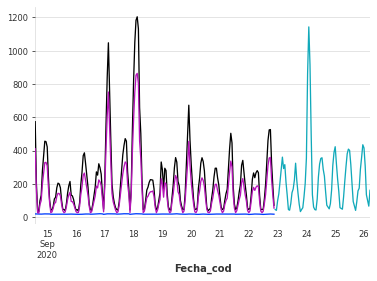

In [47]:
train[-200:].plot()
val[col_obj][:n_predict].plot()
pred.plot()

In [ ]:
# %%time
# model.backtest(val,forecast_horizon=11, verbose=True)

In [ ]:
print('MAPE: {:.2f}%'.format(mape(pred, val[col_obj])))

In [ ]:
modelo_arima = modelo

## Training (CNN)

In [96]:
df_columns = ['Pac', 'Tamb']#,'Irradiancia']

In [97]:
arr_train = train.values()
arr_train

array([[ 66.38058109,  22.02679129],
       [169.41498669,  21.72287734],
       [407.36816284,  22.83207246],
       ...,
       [323.66666667,  18.07216135],
       [188.61666667,  17.68677694],
       [ 71.16      ,  17.31298873]])

In [98]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # calcula el indice del final de la secuencia de entrada y salida actual
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # si el indice de salida es mayor que la longitud de las secuencias entonces deja de generar mas muestras
        if out_end_ix > len(sequences):
            break
            
        # separa la parte de la secuencias de entrada y el vector de traget 
        X.append( sequences[i:end_ix, :] ) # añade las secuencias de entrada a las muestras de  entrenamiento
        y.append( sequences[end_ix:out_end_ix, 0] ) # añade los n_steps_out siguientes como secuencias target de salida de la primera columna 
        
    return np.array(X), np.array(y)   

In [99]:
n_steps_in, n_steps_out = 11, 11
X, y = split_sequences(arr_train, n_steps_in, n_steps_out)
print(X.shape, y.shape)

(5611, 11, 2) (5611, 11)


In [100]:
print(X[0], y[0])

[[  66.38058109   22.02679129]
 [ 169.41498669   21.72287734]
 [ 407.36816284   22.83207246]
 [ 696.24082633   23.76986884]
 [ 946.67677087   25.17156142]
 [1113.99069828   24.87177409]
 [1225.50056522   24.46418762]
 [1208.60087474   24.22585824]
 [1054.29700341   23.27075443]
 [ 764.09652081   23.06902988]
 [ 468.34969313   22.91749311]] [  66.38058109  169.41498669  407.36816284  696.24082633  946.67677087
 1113.99069828 1225.50056522 1208.60087474 1054.29700341  764.09652081
  468.34969313]


In [101]:
X.shape

(5611, 11, 2)

In [102]:
y.shape

(5611, 11)

In [ ]:
%%time
# el numero de features es la tercera dimension del dataset
n_features = X.shape[2]   

# # aplana las secuencias de salida
# n_output = y.shape[1] * y.shape[2]
# y = y.reshape((y.shape[0], n_output))

# define el modelo
modelo_cnn = Sequential()
modelo_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
modelo_cnn.add(MaxPooling1D(pool_size=2))
modelo_cnn.add(Flatten())
modelo_cnn.add(Dense(50, activation='relu'))
modelo_cnn.add(Dense(n_steps_out))
modelo_cnn.compile(optimizer='adam', loss='mse')

# entrena el modelo Vector-Output Mulkti-step MLP con la la data de entrenamiento generada
hist_cnn = modelo_cnn.fit(X, y, epochs=3500, verbose=1)#, callbacks=[TqdmCallback(verbose=2)])




Epoch 1/3500
5611/5611 [==============================] - 1s 104us/step - loss: 87744.7119
Epoch 2/3500
5611/5611 [==============================] - 0s 87us/step - loss: 48336.4574
Epoch 3/3500
5611/5611 [==============================] - 0s 89us/step - loss: 46704.0078
Epoch 4/3500
5611/5611 [==============================] - 1s 89us/step - loss: 45275.6663
Epoch 5/3500
5611/5611 [==============================] - 0s 89us/step - loss: 44177.7533
Epoch 6/3500
5611/5611 [==============================] - 0s 88us/step - loss: 43454.8142
Epoch 7/3500
5611/5611 [==============================] - 1s 90us/step - loss: 42753.5015
Epoch 8/3500
5611/5611 [==============================] - 0s 87us/step - loss: 42168.8659
Epoch 9/3500
5611/5611 [==============================] - 1s 90us/step - loss: 41483.9218
Epoch 10/3500
5611/5611 [==============================] - 0s 88us/step - loss: 40896.4259
Epoch 11/3500
5611/5611 [==============================] - 0s 87us/step - loss: 40529.5605
Epoch 1

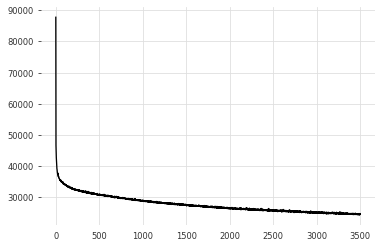

In [107]:
plt.plot(hist_cnn.history['loss'])

In [106]:
# muestra un resumen de la topologia del modelo
modelo_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_6 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


In [190]:
# modelo_cnn = modelo

In [108]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_cnn.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 14ms/step


array([[ 56.2102  ,  50.09167 , 104.692795, 199.77075 , 329.03082 ,
        466.0251  , 568.7661  , 538.9404  , 416.72266 , 247.96672 ,
         91.62496 ]], dtype=float32)

In [155]:
modelo_cnn.save('saved_models/1dcnn_Lima_HIT') #Pac, Tamb

In [156]:
new_model = tf.keras.models.load_model('saved_models/1dcnn_Lima_HIT')

# Check its architecture
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 10, 64)            320       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_6 (Dense)              (None, 11)                561       
Total params: 16,931
Trainable params: 16,931
Non-trainable params: 0
_________________________________________________________________


## Training (LSTM)

In [157]:
# my_model = RNNModel(
#     model='LSTM',
#     dropout=0,
#     batch_size=16,
#     n_epochs=300,
#     optimizer_kwargs={'lr': 1e-3}, 
#     model_name='LSTM_model',
#     log_tensorboard=True,
#     random_state=42,
#     input_chunk_length=11,
#     output_chunk_length=11
# )

In [158]:
# %%time
# my_model.fit(train[col_obj],
#              val_series=val[col_obj],
#              verbose=True)

In [159]:
df_columns = ['Pac', 'Tamb']

In [160]:
arr_train = train.values()
arr_train

array([[ 66.38058109,  22.02679129],
       [169.41498669,  21.72287734],
       [407.36816284,  22.83207246],
       ...,
       [323.66666667,  18.07216135],
       [188.61666667,  17.68677694],
       [ 71.16      ,  17.31298873]])

In [161]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # calcula el indice del final de la secuencia de entrada y salida actual
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        # si el indice de salida es mayor que la longitud de las secuencias entonces deja de generar mas muestras
        if out_end_ix > len(sequences):
            break
            
        # separa la parte de la secuencias de entrada y el vector de traget 
        X.append( sequences[i:end_ix, :] ) # añade las secuencias de entrada a las muestras de  entrenamiento
        y.append( sequences[end_ix:out_end_ix, 0] ) # añade los n_steps_out siguientes como secuencias target de salida de la primera columna 
        
    return np.array(X), np.array(y)   

In [162]:
n_steps_in, n_steps_out = 11, 11
X, y = split_sequences(arr_train, n_steps_in, n_steps_out)
print(X.shape, y.shape)

(5611, 11, 2) (5611, 11)


In [163]:
print(X[0], y[0])

[[  66.38058109   22.02679129]
 [ 169.41498669   21.72287734]
 [ 407.36816284   22.83207246]
 [ 696.24082633   23.76986884]
 [ 946.67677087   25.17156142]
 [1113.99069828   24.87177409]
 [1225.50056522   24.46418762]
 [1208.60087474   24.22585824]
 [1054.29700341   23.27075443]
 [ 764.09652081   23.06902988]
 [ 468.34969313   22.91749311]] [  66.38058109  169.41498669  407.36816284  696.24082633  946.67677087
 1113.99069828 1225.50056522 1208.60087474 1054.29700341  764.09652081
  468.34969313]


In [165]:
X.shape

(5611, 11, 2)

In [166]:
y.shape

(5611, 11)

### Modelo LSTM 1

In [167]:
%%time
# el numero de features es la tercera dimension del dataset
n_features = X.shape[2]   

# # aplana las secuencias de salida
# n_output = y.shape[1] * y.shape[2]
# y = y.reshape((y.shape[0], n_output))

# define el modelo
modelo = Sequential()
modelo.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
modelo.add(LSTM(10, activation='relu'))
modelo.add(Dense(n_steps_out))
modelo.compile(optimizer='adam', loss='mse')

# entrena el modelo Stacked LSTM Vector-Output con la la data de entrenamiento generada
hist = modelo.fit(X, y, epochs=738, verbose=1)



Epoch 1/738
5611/5611 [==============================] - 4s 670us/step - loss: 367951.1142
Epoch 2/738
5611/5611 [==============================] - 3s 480us/step - loss: 183287.0254
Epoch 3/738
5611/5611 [==============================] - 3s 481us/step - loss: 121171.0229
Epoch 4/738
5611/5611 [==============================] - 3s 497us/step - loss: 97121.3235
Epoch 5/738
5611/5611 [==============================] - 3s 475us/step - loss: 87832.0495
Epoch 6/738
5611/5611 [==============================] - 3s 473us/step - loss: 74385.7722
Epoch 7/738
5611/5611 [==============================] - 3s 476us/step - loss: 92393.9847
Epoch 8/738
5611/5611 [==============================] - 3s 476us/step - loss: 89454.6959
Epoch 9/738
5611/5611 [==============================] - 3s 478us/step - loss: 85186.5839
Epoch 10/738
5611/5611 [==============================] - 3s 478us/step - loss: 214423.1564
Epoch 11/738
5611/5611 [==============================] - 3s 476us/step - loss: 100953.4933
Epo

In [168]:
#24m

In [172]:
modelo_lstm = modelo
hist_lstm = hist

In [173]:
# muestra un resumen de la topologia del modelo
modelo_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 11, 50)            10600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense_7 (Dense)              (None, 11)                121       
Total params: 13,161
Trainable params: 13,161
Non-trainable params: 0
_________________________________________________________________


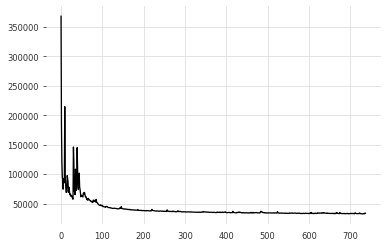

In [174]:
plt.plot(hist_lstm.history['loss'])

In [175]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_lstm.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 127ms/step


array([[ 64.679756,  75.78955 , 146.79929 , 240.61963 , 377.64206 ,
        493.6646  , 536.71155 , 496.73334 , 403.39194 , 267.98193 ,
        140.98505 ]], dtype=float32)

In [178]:
modelo_lstm.save('saved_models/lstm__Lima_HIT') #Pac, Tamb

In [179]:
new_model = tf.keras.models.load_model('saved_models/lstm__Lima_HIT')

# Check its architecture
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 11, 50)            10600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense_7 (Dense)              (None, 11)                121       
Total params: 13,161
Trainable params: 13,161
Non-trainable params: 0
_________________________________________________________________


### Modelo LSTM 2

In [73]:
%%time
# el numero de features es la tercera dimension del dataset
n_features = X.shape[2]   

# # aplana las secuencias de salida
# n_output = y.shape[1] * y.shape[2]
# y = y.reshape((y.shape[0], n_output))

# define el modelo
modelo = Sequential()
modelo.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
modelo.add(Dense(50, activation='relu'))
modelo.add(Dense(n_steps_out))
modelo.compile(optimizer='adam', loss='mse')

# entrena el modelo Stacked LSTM Vector-Output con la la data de entrenamiento generada
hist = modelo.fit(X, y, epochs=738, verbose=1)



ValueError: Error when checking target: expected dense_36 to have 3 dimensions, but got array with shape (3004, 11)

In [ ]:
#24m

In [85]:
modelo_lstm = modelo
hist_lstm = hist

In [86]:
# muestra un resumen de la topologia del modelo
modelo_lstm.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 11, 50)            10600     
_________________________________________________________________
lstm_14 (LSTM)               (None, 10)                2440      
_________________________________________________________________
dense_17 (Dense)             (None, 11)                121       
Total params: 13,161
Trainable params: 13,161
Non-trainable params: 0
_________________________________________________________________


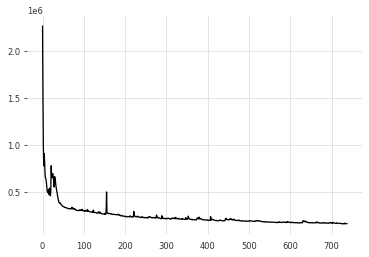

In [87]:
plt.plot(hist_lstm.history['loss'])

In [88]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_lstm.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 72ms/step


array([[ 462.38556,  889.6997 , 1500.8733 , 2040.4104 , 2376.893  ,
        2464.4165 , 2297.677  , 1913.4291 , 1404.0825 ,  824.12726,
         425.62314]], dtype=float32)

## Training (Baseline)

In [577]:
class baseline_model:
    history = None
    def fit(self, history):
        self.history = history
    def predict(self, n, col_obj):
        assert self.history is not None, 'Es necesario realizar entrenamiento (fit)'
        return self.history[-11:-11+n][col_obj] ##No utilizar indices

In [501]:
f = baseline_model()
f.fit(train)
f.predict(2, col_obj)
##No utilizar indices

                             Pac
Fecha_cod                       
2017-05-06 20:00:00   433.067083
2017-05-06 21:00:00  1179.527500
Freq: H

# Comparación de modelos


### Definicion Walkforward

In [576]:
def walk_forward_evaluation(train, val, model, n_pred, col_obj, es_neuronal=False):
    assert len(val)//n_pred >= 2, "Deben haber mínimo 2 días (periodos de pronóstico) de validación"
    history = train
    if es_neuronal:
        pass #model.fit(train)
    arr_pred=None
    arr_real=None 
    for t in range(len(val)-n_pred):
        print(f't={t}/{len(val)-n_pred-1}')
        print(f'history len = {len(history)}')
        print()
        
        #valores predichos
        if not es_neuronal:
            model.fit(history[col_obj])
            pred = model.predict(n_pred)
        if not isinstance(pred, np.ndarray):
            pred = pred.univariate_values().reshape((1,-1))
        else:
            pred = pred.reshape((1,-1))
        if arr_pred is None:
            arr_pred = pred
        else:
            arr_pred = np.concatenate([arr_pred,pred], axis=0)
            
        #valores reales:
        real = val[t:t+n_pred][col_obj].univariate_values().reshape((1,-1))
        if arr_real is None:
            arr_real = real
        else:
            arr_real = np.concatenate([arr_real,real], axis=0)
        #history_new = history.append(val[t])
        #history = history_new
        history = history.append(val[t])
    
    return arr_pred, arr_real
    

#### Walk forward para modelos neuronales

In [180]:
def walk_forward_evaluation_neuronal(train, val, model, n_pred, col_obj, es_neuronal=True):
    assert len(val)//n_pred >= 2, "Deben haber mínimo 2 días (periodos de pronóstico) de validación"
    x_input = train[-11:]
    if es_neuronal:
        pass #model.fit(train)
    
    arr_pred=None
    arr_real=None 
    for t in range(val.shape[0]-n_pred):
        if (t%100 == 0) or (t == (val.shape[0]-n_pred-1)):
            print(f't={t}/{val.shape[0]-n_pred-1}')
            print(f'history len = {x_input.shape[0]}')
            print()
        
        #valores predichos
        if not es_neuronal:
#             model.fit(history[col_obj])
            pred = model.predict(n_pred)
        else:
            pred = model.predict(x_input.reshape((1, 11, train.shape[1])) )
            
        if not isinstance(pred, np.ndarray):
            pred = pred.univariate_values().reshape((1,-1))
        else:
            pred = pred.reshape((1,-1))
            
        if arr_pred is None:
            arr_pred = pred
        else:
            arr_pred = np.concatenate([arr_pred,pred], axis=0)
            
        #valores reales:
        if not es_neuronal:
            real = val[t:t+n_pred][col_obj].univariate_values().reshape((1,-1))
        else:
            real = val[t:t+n_pred,0].reshape((1,-1))
        if arr_real is None:
            arr_real = real
        else:
            arr_real = np.concatenate([arr_real,real], axis=0)
        #history_new = history.append(val[t])
        #history = history_new
        x_input = np.vstack((x_input[1:],val[t]))
    
    return arr_pred, arr_real
    

### Prediction ARIMA

In [ ]:
model = ARIMA(p=2, d=0, q=11)
n_pred = 11
val_wfe = val[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train
print(len(train_wfe))
print(len(val_wfe))

In [436]:
%%time
model.fit(train[col_obj])

CPU times: user 10min 28s, sys: 11min 41s, total: 22min 9s
Wall time: 55.6 s


In [437]:
n_predict = 80

In [438]:
%%time
pred = model.predict(n_predict)
pred

CPU times: user 478 ms, sys: 523 ms, total: 1 s
Wall time: 41.8 ms


                               0
2017-05-07 07:00:00   347.063028
2017-05-07 08:00:00   641.926299
2017-05-07 09:00:00  1174.898180
2017-05-07 10:00:00  1743.496876
2017-05-07 11:00:00  2156.955701
...                          ...
2017-05-10 10:00:00   722.461815
2017-05-10 11:00:00   389.781913
2017-05-10 12:00:00   336.146406
2017-05-10 13:00:00   577.850294
2017-05-10 14:00:00  1037.568886

[80 rows x 1 columns]
Freq: H

In [439]:
val[:100]

                             Pac       Tamb
Fecha_cod                                  
2017-05-07 07:00:00   434.088750  14.522917
2017-05-07 08:00:00  1170.127083  19.560417
2017-05-07 09:00:00  1785.090417  24.650000
2017-05-07 10:00:00  2249.656667  24.322500
2017-05-07 11:00:00  2549.714167  24.848750
...                          ...        ...
2017-05-11 06:00:00  2071.770833  24.311667
2017-05-11 07:00:00  1410.895000  23.180833
2017-05-11 08:00:00  1132.319583  23.412083
2017-05-11 09:00:00   536.687917  21.356250
2017-05-11 10:00:00   309.435833  17.710417

[100 rows x 2 columns]
Freq: H

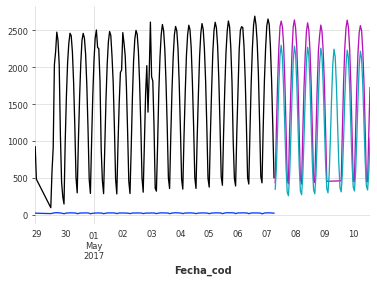

In [440]:
train[-200:].plot()
val[col_obj][:n_predict].plot()
pred.plot()

In [329]:
# %%time
# model.backtest(val,forecast_horizon=11, verbose=True)

In [441]:
print('MAPE: {:.2f}%'.format(mape(pred, val[col_obj])))

MAPE: 46.25%


In [319]:
# print('MAPE: {:.2f}%'.format(mape(pred, val[col_obj])))

MAPE: 33.43%


#### Walk forward ARIMA

In [460]:
model = ARIMA(p=2, d=0, q=11)
n_pred = 11
val_wfe = val[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train
print(len(train_wfe))
print(len(val_wfe))

3025
33


In [461]:
%%time
arr_pred, arr_real = walk_forward_evaluation(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=False)

t=0/21
history len = 3025

t=1/21
history len = 3026

t=2/21
history len = 3027

t=3/21
history len = 3028

t=4/21
history len = 3029

t=5/21
history len = 3030

t=6/21
history len = 3031

t=7/21
history len = 3032

t=8/21
history len = 3033

t=9/21
history len = 3034

t=10/21
history len = 3035

t=11/21
history len = 3036

t=12/21
history len = 3037

t=13/21
history len = 3038

t=14/21
history len = 3039

t=15/21
history len = 3040

t=16/21
history len = 3041

t=17/21
history len = 3042

t=18/21
history len = 3043

t=19/21
history len = 3044

t=20/21
history len = 3045

t=21/21
history len = 3046

CPU times: user 5h 5min 9s, sys: 6h 20min 43s, total: 11h 25min 52s
Wall time: 36min 57s


In [462]:
arr_pred.shape

(22, 11)

In [463]:
arr_real.shape

(22, 11)

#### Metric Evaluation ARIMA

In [464]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [465]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([160.64776544, 270.69151432, 315.9885493 , 334.01812193,
       348.00484558, 372.36320726, 403.76765114, 427.86701613,
       436.60018178, 432.48102117, 439.43991836])

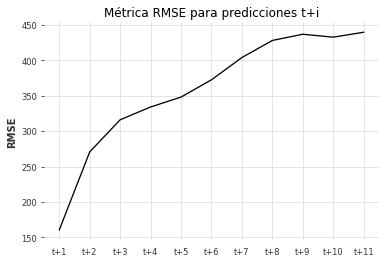

In [466]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [467]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.95698311, 0.8716135 , 0.8166354 , 0.78997067, 0.77035765,
       0.73757084, 0.69279894, 0.65660533, 0.64425295, 0.65094365,
       0.63929683])

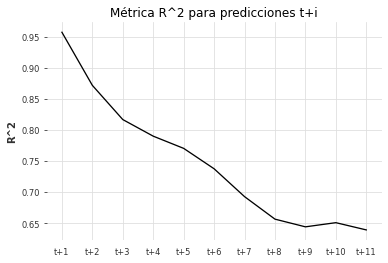

In [468]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

###  Predicción Baseline

In [506]:
n_pred = 11
val_wfe = val[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train
print(len(train_wfe))
print(len(val_wfe))

3025
33


In [579]:
class baseline_model:
    history = None
    n_pred = 11
    def fit(self, history):
        self.history = history
    def predict(self, n):
        assert self.history is not None, 'Es necesario realizar entrenamiento (fit)'
        assert n<=self.n_pred, f'n debe ser menor a self.n_pred ({self.n_pred})'
        if n>=self.n_pred:
            return self.history[-self.n_pred:]
        return self.history[-self.n_pred:-self.n_pred+n] ##No utilizar indices

In [566]:
f = baseline_model()
f.fit(train_wfe)
f.predict(11)
##No utilizar indices

                             Pac       Tamb
Fecha_cod                                  
2017-05-06 20:00:00   433.067083  13.104167
2017-05-06 21:00:00  1179.527500  18.623333
2017-05-06 22:00:00  1814.646667  24.077083
2017-05-06 23:00:00  2256.192917  25.899583
2017-05-07 00:00:00  2561.787083  26.175417
2017-05-07 01:00:00  2653.807083  26.612917
2017-05-07 02:00:00  2582.510417  26.527917
2017-05-07 03:00:00  2287.591250  26.619583
2017-05-07 04:00:00  1820.930000  25.294583
2017-05-07 05:00:00  1200.292917  23.883333
2017-05-07 06:00:00   502.802929  22.205439
Freq: H

### Walk Forward Baseline

In [567]:
model = baseline_model()
n_pred = 11
val_wfe = val[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train
print(len(train_wfe))
print(len(val_wfe))

3025
33


In [568]:
%%time
arr_pred, arr_real = walk_forward_evaluation(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=False)

t=0/21
history len = 3025

t=1/21
history len = 3026

t=2/21
history len = 3027

t=3/21
history len = 3028

t=4/21
history len = 3029

t=5/21
history len = 3030

t=6/21
history len = 3031

t=7/21
history len = 3032

t=8/21
history len = 3033

t=9/21
history len = 3034

t=10/21
history len = 3035

t=11/21
history len = 3036

t=12/21
history len = 3037

t=13/21
history len = 3038

t=14/21
history len = 3039

t=15/21
history len = 3040

t=16/21
history len = 3041

t=17/21
history len = 3042

t=18/21
history len = 3043

t=19/21
history len = 3044

t=20/21
history len = 3045

t=21/21
history len = 3046

CPU times: user 303 ms, sys: 0 ns, total: 303 ms
Wall time: 295 ms


In [569]:
arr_pred

array([[ 433.06708333, 1179.5275    , 1814.64666667, 2256.19291667,
        2561.78708333, 2653.80708333, 2582.51041667, 2287.59125   ,
        1820.93      , 1200.29291667,  502.80292887],
       [1179.5275    , 1814.64666667, 2256.19291667, 2561.78708333,
        2653.80708333, 2582.51041667, 2287.59125   , 1820.93      ,
        1200.29291667,  502.80292887,  434.08875   ],
       [1814.64666667, 2256.19291667, 2561.78708333, 2653.80708333,
        2582.51041667, 2287.59125   , 1820.93      , 1200.29291667,
         502.80292887,  434.08875   , 1170.12708333],
       [2256.19291667, 2561.78708333, 2653.80708333, 2582.51041667,
        2287.59125   , 1820.93      , 1200.29291667,  502.80292887,
         434.08875   , 1170.12708333, 1785.09041667],
       [2561.78708333, 2653.80708333, 2582.51041667, 2287.59125   ,
        1820.93      , 1200.29291667,  502.80292887,  434.08875   ,
        1170.12708333, 1785.09041667, 2249.65666667],
       [2653.80708333, 2582.51041667, 2287.59125  

In [570]:
arr_real

array([[ 434.08875   , 1170.12708333, 1785.09041667, 2249.65666667,
        2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333],
       [1170.12708333, 1785.09041667, 2249.65666667, 2549.71416667,
        2626.0275    , 2549.17375   , 2307.63208333, 1830.59958333,
        1196.37333333,  483.49708333,  419.27583333],
       [1785.09041667, 2249.65666667, 2549.71416667, 2626.0275    ,
        2549.17375   , 2307.63208333, 1830.59958333, 1196.37333333,
         483.49708333,  419.27583333, 1134.27166667],
       [2249.65666667, 2549.71416667, 2626.0275    , 2549.17375   ,
        2307.63208333, 1830.59958333, 1196.37333333,  483.49708333,
         419.27583333, 1134.27166667, 1675.97208333],
       [2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333,  419.27583333,
        1134.27166667, 1675.97208333, 2210.39333333],
       [2626.0275    , 2549.17375   , 2307.6320833

#### Metric Evaluation Baseline

In [571]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [572]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([37.95487422, 37.95728727, 38.30072428, 39.2570819 , 40.79120364,
       43.14413184, 43.56537003, 43.23455526, 44.20596312, 44.68720473,
       44.91275993])

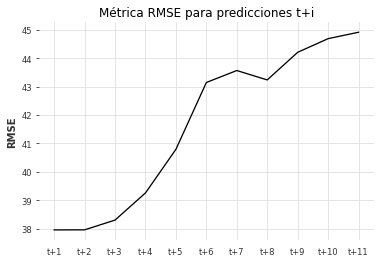

In [573]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [574]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.99760507, 0.99761134, 0.99757768, 0.99745508, 0.99724291,
       0.99690913, 0.99684312, 0.99687132, 0.99672303, 0.9966502 ,
       0.99664528])

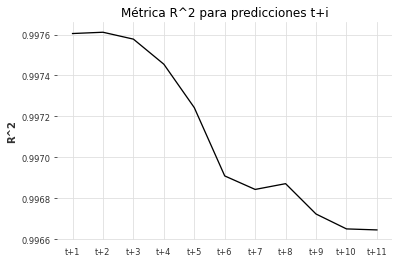

In [575]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

### Prediction CNN


In [110]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_cnn.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 1ms/step


array([[ 56.2102  ,  50.09167 , 104.692795, 199.77075 , 329.03082 ,
        466.0251  , 568.7661  , 538.9404  , 416.72266 , 247.96672 ,
         91.62496 ]], dtype=float32)

In [111]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_cnn.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 1ms/step


array([[ 56.2102  ,  50.09167 , 104.692795, 199.77075 , 329.03082 ,
        466.0251  , 568.7661  , 538.9404  , 416.72266 , 247.96672 ,
         91.62496 ]], dtype=float32)

### Walk Forward CNN 2

In [144]:
model = modelo_cnn
n_pred = 11
val_wfe = val.values()#[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train.values()
print(len(train_wfe))
print(len(val_wfe))

5632
1397


In [145]:
n_features

2

In [146]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/1385
history len = 11

t=100/1385
history len = 11

t=200/1385
history len = 11

t=300/1385
history len = 11

t=400/1385
history len = 11

t=500/1385
history len = 11

t=600/1385
history len = 11

t=700/1385
history len = 11

t=800/1385
history len = 11

t=900/1385
history len = 11

t=1000/1385
history len = 11

t=1100/1385
history len = 11

t=1200/1385
history len = 11

t=1300/1385
history len = 11

t=1385/1385
history len = 11

CPU times: user 928 ms, sys: 39.3 ms, total: 968 ms
Wall time: 788 ms


In [147]:
arr_pred

array([[ 56.2102  ,  50.09167 , 104.692795, ..., 416.72266 , 247.96672 ,
         91.62496 ],
       [ 28.819895,  87.65398 , 199.16597 , ..., 196.51837 ,  60.459   ,
         47.183712],
       [ 66.59489 , 155.80005 , 278.867   , ..., 116.31206 ,  89.781525,
        113.59646 ],
       ...,
       [770.0845  , 564.2731  , 399.16193 , ..., 937.2644  , 975.8807  ,
        911.73175 ],
       [487.3433  , 259.8892  ,  45.774315, ..., 948.62476 , 929.3677  ,
        774.5289  ],
       [410.82062 , 166.34291 , 184.61902 , ..., 875.70416 , 742.0723  ,
        524.69293 ]], dtype=float32)

In [148]:
arr_real

array([[  45.32142857,   40.38888889,   98.13333333, ...,  315.28333333,
         209.33333333,  131.91666667],
       [  40.38888889,   98.13333333,  139.2       , ...,  209.33333333,
         131.91666667,   45.32142857],
       [  98.13333333,  139.2       ,  211.08333333, ...,  131.91666667,
          45.32142857,   41.30434783],
       ...,
       [ 814.85      ,  650.1       ,  241.23333333, ..., 1251.51666667,
        1108.41666667,  785.08333333],
       [ 650.1       ,  241.23333333,   64.24703484, ..., 1108.41666667,
         785.08333333,  495.4       ],
       [ 241.23333333,   64.24703484,  139.91666667, ...,  785.08333333,
         495.4       ,  303.36666667]])

#### Metric Evaluation CNN

In [149]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [150]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([ 91.04837875, 130.68616664, 156.7760979 , 173.05450812,
       186.8498645 , 193.36957317, 194.62003186, 189.87498731,
       187.82855043, 183.31835788, 176.44706627])

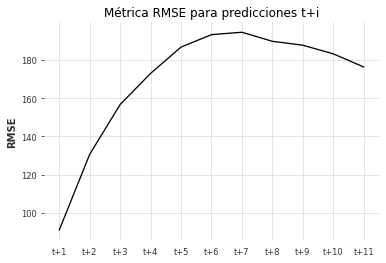

In [151]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [152]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.88990165, 0.7746077 , 0.66727508, 0.5764789 , 0.50170549,
       0.46844339, 0.47557721, 0.4839345 , 0.47046291, 0.46218942,
       0.48701839])

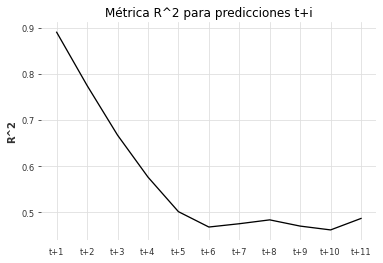

In [153]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

### Walk Forward CNN

In [215]:
model = modelo_cnn
n_pred = 11
val_wfe = val.values()[:n_pred*2]#[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train.values()
print(len(train_wfe))
print(len(val_wfe))

5632
22


In [216]:
n_features

2

In [217]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/10
history len = 11

t=10/10
history len = 11

CPU times: user 17.7 ms, sys: 48 µs, total: 17.8 ms
Wall time: 14.1 ms


In [218]:
arr_pred

array([[ 56.2102   ,  50.09167  , 104.692795 , 199.77075  , 329.03082  ,
        466.0251   , 568.7661   , 538.9404   , 416.72266  , 247.96672  ,
         91.62496  ],
       [ 28.819895 ,  87.65398  , 199.16597  , 323.23587  , 478.729    ,
        557.87775  , 529.5595   , 381.4218   , 196.51837  ,  60.459    ,
         47.183712 ],
       [ 66.59489  , 155.80005  , 278.867    , 408.2602   , 469.0633   ,
        483.36136  , 390.0575   , 236.82278  , 116.31206  ,  89.781525 ,
        113.59646  ],
       [117.10946  , 195.4359   , 290.4819   , 368.18094  , 370.1308   ,
        330.21664  , 193.37527  ,  45.78559  ,   6.0791817,  71.18748  ,
        187.2978   ],
       [224.59154  , 331.48962  , 419.80435  , 407.3938   , 332.8806   ,
        197.33934  ,  90.820526 ,  56.53115  ,  91.52798  , 207.36023  ,
        358.18542  ],
       [310.3818   , 395.58972  , 391.50595  , 334.61404  , 223.13248  ,
        105.385025 ,  71.91383  , 104.293076 , 168.56813  , 304.37863  ,
        413.05

In [219]:
arr_real

array([[ 45.32142857,  40.38888889,  98.13333333, 139.2       ,
        211.08333333, 285.71666667, 360.43333333, 291.5       ,
        315.28333333, 209.33333333, 131.91666667],
       [ 40.38888889,  98.13333333, 139.2       , 211.08333333,
        285.71666667, 360.43333333, 291.5       , 315.28333333,
        209.33333333, 131.91666667,  45.32142857],
       [ 98.13333333, 139.2       , 211.08333333, 285.71666667,
        360.43333333, 291.5       , 315.28333333, 209.33333333,
        131.91666667,  45.32142857,  41.30434783],
       [139.2       , 211.08333333, 285.71666667, 360.43333333,
        291.5       , 315.28333333, 209.33333333, 131.91666667,
         45.32142857,  41.30434783,  81.56666667],
       [211.08333333, 285.71666667, 360.43333333, 291.5       ,
        315.28333333, 209.33333333, 131.91666667,  45.32142857,
         41.30434783,  81.56666667, 146.55      ],
       [285.71666667, 360.43333333, 291.5       , 315.28333333,
        209.33333333, 131.91666667,  45.3

#### Metric Evaluation CNN

In [220]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [221]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([ 47.19296331,  45.09573109,  62.3620712 ,  83.94432657,
        93.13145034, 120.83996759, 129.75774247, 127.29817758,
       130.61784692, 156.56328675, 189.18524738])

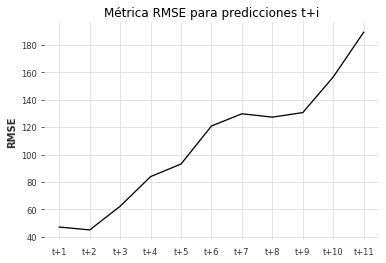

In [222]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [223]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([ 0.80959656,  0.86114454,  0.76346626,  0.68211066,  0.68013099,
        0.53333214,  0.48248422,  0.39448235,  0.30236077, -0.12141161,
       -0.40042807])

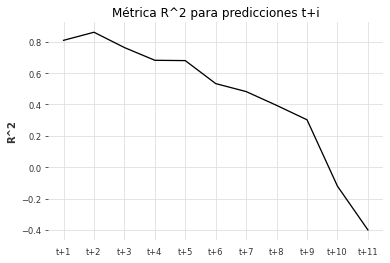

In [224]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

### Prediction LSTM


In [181]:
x_input = train[-11:].values()
x_input = x_input.reshape((1, n_steps_in, n_features)) 
y_hat = modelo_lstm.predict(x_input, verbose=1)
y_hat

1/1 [==============================] - 0s 4ms/step


array([[ 64.679756,  75.78955 , 146.79929 , 240.61963 , 377.64206 ,
        493.6646  , 536.71155 , 496.73334 , 403.39194 , 267.98193 ,
        140.98505 ]], dtype=float32)

### Walk Forward LSTM 2

In [225]:
model = modelo_lstm
n_pred = 11
val_wfe = val.values()#[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train.values()
print(len(train_wfe))
print(len(val_wfe))

5632
1397


In [226]:
n_features

2

In [227]:
val_wfe.shape

(1397, 2)

In [232]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/1385
history len = 11

t=100/1385
history len = 11

t=200/1385
history len = 11

t=300/1385
history len = 11

t=400/1385
history len = 11

t=500/1385
history len = 11

t=600/1385
history len = 11

t=700/1385
history len = 11

t=800/1385
history len = 11

t=900/1385
history len = 11

t=1000/1385
history len = 11

t=1100/1385
history len = 11

t=1200/1385
history len = 11

t=1300/1385
history len = 11

t=1385/1385
history len = 11

CPU times: user 9.81 s, sys: 2.1 s, total: 11.9 s
Wall time: 4.57 s


In [233]:
arr_pred

array([[  64.679756 ,   75.78955  ,  146.79929  , ...,  403.39194  ,
         267.98193  ,  140.98505  ],
       [   6.4047136,   75.42864  ,  188.29865  , ...,  314.6412   ,
         160.68279  ,   39.892242 ],
       [ 157.26956  ,  322.62524  ,  455.84814  , ...,   73.33053  ,
          15.278293 ,   45.62206  ],
       ...,
       [ 936.5982   ,  679.0337   ,  394.04056  , ...,  955.9159   ,
        1034.6641   , 1005.683    ],
       [ 533.3449   ,  332.82822  ,  164.11612  , ...,  911.429    ,
         918.3812   ,  810.35706  ],
       [ 364.34146  ,  116.88925  ,  125.18579  , ...,  866.17737  ,
         733.8957   ,  514.8956   ]], dtype=float32)

In [234]:
arr_real

array([[  45.32142857,   40.38888889,   98.13333333, ...,  315.28333333,
         209.33333333,  131.91666667],
       [  40.38888889,   98.13333333,  139.2       , ...,  209.33333333,
         131.91666667,   45.32142857],
       [  98.13333333,  139.2       ,  211.08333333, ...,  131.91666667,
          45.32142857,   41.30434783],
       ...,
       [ 814.85      ,  650.1       ,  241.23333333, ..., 1251.51666667,
        1108.41666667,  785.08333333],
       [ 650.1       ,  241.23333333,   64.24703484, ..., 1108.41666667,
         785.08333333,  495.4       ],
       [ 241.23333333,   64.24703484,  139.91666667, ...,  785.08333333,
         495.4       ,  303.36666667]])

#### Metric Evaluation LSTM

In [235]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [236]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([ 95.19900802, 125.90094084, 149.38040053, 163.4668379 ,
       171.48053134, 175.22217285, 174.5038797 , 173.32719114,
       174.11385683, 174.54546356, 170.88491136])

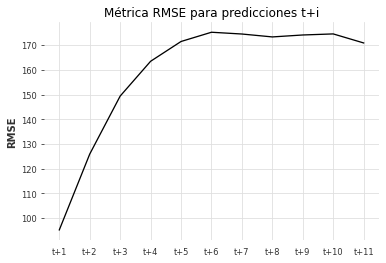

In [237]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [238]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.89128577, 0.78082358, 0.6640887 , 0.57833441, 0.50235336,
       0.47064082, 0.47907496, 0.47776851, 0.47421872, 0.48114476,
       0.51787574])

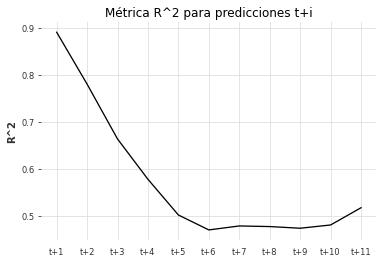

In [239]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

### Walk Forward LSTM

In [187]:
model = modelo_lstm
n_pred = 11
val_wfe = val.values()[:n_pred*3] # Minimo 2 dias
# train_wfe = train[-n_pred*40:]
train_wfe = train.values()
print(len(train_wfe))
print(len(val_wfe))

3025
33


In [188]:
n_features

2

In [189]:
%%time
arr_pred, arr_real = walk_forward_evaluation_neuronal(train=train_wfe, val=val_wfe, model=model, n_pred=n_pred,col_obj=col_obj, es_neuronal=True)


t=0/21
history len = 11

t=1/21
history len = 11

t=2/21
history len = 11

t=3/21
history len = 11

t=4/21
history len = 11

t=5/21
history len = 11

t=6/21
history len = 11

t=7/21
history len = 11

t=8/21
history len = 11

t=9/21
history len = 11

t=10/21
history len = 11

t=11/21
history len = 11

t=12/21
history len = 11

t=13/21
history len = 11

t=14/21
history len = 11

t=15/21
history len = 11

t=16/21
history len = 11

t=17/21
history len = 11

t=18/21
history len = 11

t=19/21
history len = 11

t=20/21
history len = 11

t=21/21
history len = 11

CPU times: user 238 ms, sys: 67.2 ms, total: 305 ms
Wall time: 102 ms


In [190]:
arr_pred

array([[ 462.38556,  889.6997 , 1500.8733 , 2040.4104 , 2376.893  ,
        2464.4165 , 2297.677  , 1913.4291 , 1404.0825 ,  824.12726,
         425.62314],
       [ 737.5334 , 1241.9738 , 1720.9745 , 2091.577  , 2285.7573 ,
        2280.4714 , 2039.9794 , 1579.5532 ,  986.767  ,  465.55008,
         379.3336 ],
       [1708.7362 , 2033.2561 , 2169.305  , 2285.4094 , 2399.606  ,
        2276.7283 , 1734.406  ,  988.9572 ,  515.4057 ,  562.57416,
        1035.902  ],
       [2146.0974 , 2341.3909 , 2341.6892 , 2238.6692 , 2063.3533 ,
        1654.9498 , 1020.3772 ,  512.823  ,  541.0208 , 1062.4093 ,
        1715.3575 ],
       [2357.3774 , 2431.8064 , 2301.9375 , 1942.7925 , 1433.8888 ,
         880.18823,  506.30902,  562.7502 , 1056.2153 , 1673.8301 ,
        2184.635  ],
       [2513.2107 , 2453.1042 , 2152.5264 , 1581.799  ,  896.07104,
         406.41943,  395.2406 ,  908.8264 , 1604.0752 , 2086.71   ,
        2391.2146 ],
       [2407.9592 , 2057.7625 , 1500.4854 ,  858.83453,  3

In [191]:
arr_real

array([[ 434.08875   , 1170.12708333, 1785.09041667, 2249.65666667,
        2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333],
       [1170.12708333, 1785.09041667, 2249.65666667, 2549.71416667,
        2626.0275    , 2549.17375   , 2307.63208333, 1830.59958333,
        1196.37333333,  483.49708333,  419.27583333],
       [1785.09041667, 2249.65666667, 2549.71416667, 2626.0275    ,
        2549.17375   , 2307.63208333, 1830.59958333, 1196.37333333,
         483.49708333,  419.27583333, 1134.27166667],
       [2249.65666667, 2549.71416667, 2626.0275    , 2549.17375   ,
        2307.63208333, 1830.59958333, 1196.37333333,  483.49708333,
         419.27583333, 1134.27166667, 1675.97208333],
       [2549.71416667, 2626.0275    , 2549.17375   , 2307.63208333,
        1830.59958333, 1196.37333333,  483.49708333,  419.27583333,
        1134.27166667, 1675.97208333, 2210.39333333],
       [2626.0275    , 2549.17375   , 2307.6320833

#### Metric Evaluation LSTM

In [192]:
def evaluate_metric_t(arr_pred, arr_real, metric):
    num_cols = arr_pred.shape[1]
    ls_metric = np.zeros(num_cols)
    for col in range(num_cols):
        ls_metric[col] = metric(arr_pred[:,col], arr_real[:,col])
    return ls_metric
    

##### RMSE

In [193]:
metric = rmse
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([197.55610394, 238.56362632, 305.55899102, 324.96683809,
       274.55980543, 231.67606308, 221.54597819, 211.42255549,
       184.07502815, 164.89740173, 124.90828435])

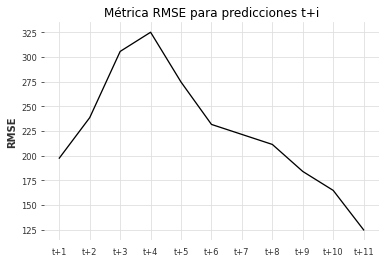

In [194]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

##### R^2

In [195]:
metric = r2_score
ls_metric_t = evaluate_metric_t(arr_pred, arr_real, metric=metric)
ls_metric_t

array([0.9354495 , 0.8969718 , 0.8117387 , 0.78788145, 0.86891083,
       0.9153973 , 0.91270125, 0.90583947, 0.93250621, 0.94930829,
       0.97196451])

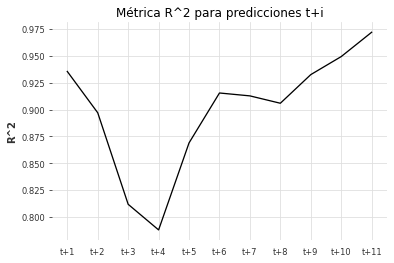

In [196]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.show()

In [197]:
modelo_cnn.predict(x_input, verbose=1)

1/1 [==============================] - 0s 1ms/step


array([[ 414.4701,  991.9556, 1628.1176, 2084.6936, 2385.5737, 2474.6086,
        2354.728 , 2069.403 , 1706.6467, 1136.0331,  471.2032]],
      dtype=float32)

In [198]:
modelo_lstm.predict(x_input, verbose=1)

1/1 [==============================] - 0s 5ms/step


array([[ 462.38556,  889.6997 , 1500.8733 , 2040.4104 , 2376.893  ,
        2464.4165 , 2297.677  , 1913.4291 , 1404.0825 ,  824.12726,
         425.62314]], dtype=float32)

### Comapración de Análisis Walk Forward

In [219]:
rmse_arima = np.array([160.64776544, 270.69151432, 315.9885493 , 334.01812193,
       348.00484558, 372.36320726, 403.76765114, 427.86701613,
       436.60018178, 432.48102117, 439.43991836])
rmse_baseline = np.array([37.95487422, 37.95728727, 38.30072428, 39.2570819 , 40.79120364,
       43.14413184, 43.56537003, 43.23455526, 44.20596312, 44.68720473,
       44.91275993])
rmse_cnn = np.array([ 66.03059827, 124.09463853, 152.07329848, 140.44600895,
       128.4332031 , 137.22035643, 117.07118223, 129.04759466,
       147.78023468, 166.15645215, 130.88758569])
rmse_lstm = np.array([197.55610394, 238.56362632, 305.55899102, 324.96683809,
       274.55980543, 231.67606308, 221.54597819, 211.42255549,
       184.07502815, 164.89740173, 124.90828435])
ls_rmse = [  rmse_arima,rmse_cnn,rmse_lstm,rmse_baseline]

In [220]:
r2_arima = np.array([0.95698311, 0.8716135 , 0.8166354 , 0.78997067, 0.77035765,
       0.73757084, 0.69279894, 0.65660533, 0.64425295, 0.65094365,
       0.63929683])
r2_baseline = np.array([0.99760507, 0.99761134, 0.99757768, 0.99745508, 0.99724291,
       0.99690913, 0.99684312, 0.99687132, 0.99672303, 0.9966502 ,
       0.99664528])
r2_cnn = np.array([0.99245755, 0.97053042, 0.95181674, 0.95881791, 0.96936259,
       0.96646702, 0.9756328 , 0.97043425, 0.96130104, 0.9557406 ,
       0.97213966])
r2_lstm = np.array([0.9354495 , 0.8969718 , 0.8117387 , 0.78788145, 0.86891083,
       0.9153973 , 0.91270125, 0.90583947, 0.93250621, 0.94930829,
       0.97196451])
ls_r2 = [ r2_arima, r2_cnn,r2_lstm,r2_baseline]

In [221]:
nombres_modelos = [ 'ARIMA', 'CNN', 'LSTM','Baseline']

#### Comparación de métrica RMSE 

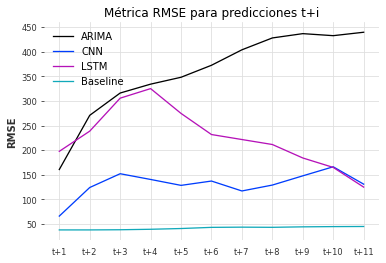

In [222]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
for ls_metric_t in ls_rmse:
    plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.legend(nombres_modelos)
plt.show()

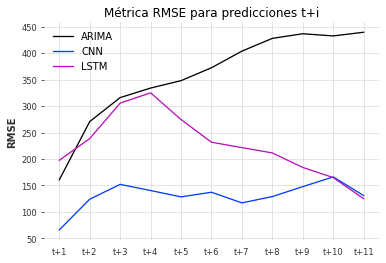

In [223]:
plt.title('Métrica RMSE para predicciones t+i')
plt.ylabel('RMSE')
for ls_metric_t in ls_rmse[:-1]:
    plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.legend(nombres_modelos[:-1])
plt.show()

#### Comparación de métrica R^2

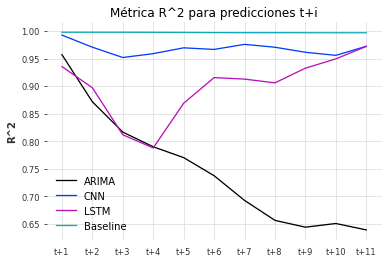

In [226]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
for ls_metric_t in ls_r2:
    plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.legend(nombres_modelos)
plt.show()

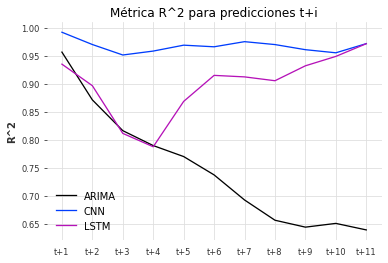

In [227]:
plt.title('Métrica R^2 para predicciones t+i')
plt.ylabel('R^2')
for ls_metric_t in ls_r2[:-1]:
    plt.plot([f't+{i}' for i in range(1,n_pred+1)],ls_metric_t)
plt.legend(nombres_modelos[:-1])
plt.show()